# Water Quality Prediction
Author(s): Amy Ou, Bryan Flores, Trevor Sauerbrey

In [30]:
''' Dependencies '''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from tabulate import tabulate
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ML
from sklearn.impute import KNNImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

In [6]:
''' Import CSV '''
# Import CSV
water = pd.read_csv('./data/water_potability.csv')

# Display the first few rows of the DataFrame using tabulate
sample_table = water.head()
table_str = tabulate(sample_table, headers='keys', tablefmt='pretty', showindex=False)

print(table_str)

+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------+
|        ph         |      Hardness      |       Solids       |    Chloramines    |      Sulfate       |   Conductivity    |   Organic_carbon   |  Trihalomethanes   |     Turbidity      | Potability |
+-------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+------------+
|        nan        | 204.8904554713363  | 20791.318980747023 | 7.300211873184757 | 368.51644134980336 | 564.3086541722439 |  10.3797830780847  |  86.9909704615088  | 2.9631353806316407 |    0.0     |
| 3.71608007538699  | 129.42292051494425 | 18630.057857970347 |  6.635245883862   |        nan         | 592.8853591348523 | 15.18001311635726  | 56.32907628451764  | 4.500656274942408  |    0.0  

## Exploratory Analysis

In [7]:
# Analyze and Summarize Data
def analyze_data(df):
    """
    Analyze and summarize a DataFrame's characteristics.

    Parameters:
    df (pd.DataFrame): The input DataFrame to be analyzed.

    Returns:
    pd.DataFrame: A summary DataFrame containing various statistics about the input data.
    """
    print(f"Dataset Shape: {df.shape}")

    # Initialize summary DataFrame with data types
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])

    # Reset index and assign column names for better presentation
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]

    # Count missing values and unique values
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values

    # Calculate entropy, skewness, kurtosis, and statistical measures for numeric columns
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2), 2)

        if df[name].dtype in ['float64', 'int64']:
            summary.loc[summary['Name'] == name, 'Skewness'] = round(stats.skew(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Kurtosis'] = round(stats.kurtosis(df[name]), 2)
            summary.loc[summary['Name'] == name, 'Min'] = df[name].min()
            summary.loc[summary['Name'] == name, 'Mean'] = df[name].mean()
            summary.loc[summary['Name'] == name, 'Median'] = df[name].median()
            summary.loc[summary['Name'] == name, 'Max'] = df[name].max()
            summary.loc[summary['Name'] == name, 'Std'] = df[name].std()

            # Outlier detection using IQR
            Q1 = df[name].quantile(0.25)
            Q3 = df[name].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[name] < Q1 - 1.5 * IQR) | (df[name] > Q3 + 1.5 * IQR)]
            summary.loc[summary['Name'] == name, 'Outliers'] = len(outliers)

    return summary

# Analyze the 'water' dataset and store the summary
summary = analyze_data(water)

# Rounding all numeric columns to three decimals
numeric_cols = ['Missing', 'Uniques', 'First Value', 'Entropy', 'Skewness', 'Kurtosis',
                'Min', 'Mean', 'Median', 'Max', 'Std', 'Outliers']
summary[numeric_cols] = summary[numeric_cols].round(3)

# Formatting the summary DataFrame for tabulation
summary_table = summary[['Name', 'dtypes', 'Missing', 'Uniques', 'First Value', 'Entropy', 
                         'Skewness', 'Kurtosis', 'Min', 'Mean', 'Median', 'Max', 'Std', 'Outliers']]

# Convert the table to a formatted string
table_str = tabulate(summary_table, headers='keys', tablefmt='pretty', showindex=False)

print(table_str)

Dataset Shape: (3276, 10)
+-----------------+---------+---------+---------+-------------+---------+----------+----------+---------+-----------+-----------+-----------+----------+----------+
|      Name       | dtypes  | Missing | Uniques | First Value | Entropy | Skewness | Kurtosis |   Min   |   Mean    |  Median   |    Max    |   Std    | Outliers |
+-----------------+---------+---------+---------+-------------+---------+----------+----------+---------+-----------+-----------+-----------+----------+----------+
|       ph        | float64 |   491   |  2785   |     nan     |  11.44  |   nan    |   nan    |   0.0   |   7.081   |   7.037   |   14.0    |  1.594   |   46.0   |
|    Hardness     | float64 |    0    |  3276   |   204.89    |  11.68  |  -0.04   |   0.61   | 47.432  |  196.369  |  196.968  |  323.124  |  32.88   |   83.0   |
|     Solids      | float64 |    0    |  3276   |  20791.319  |  11.68  |   0.62   |   0.44   | 320.943 | 22014.093 | 20927.834 | 61227.196 | 8768.571 |  

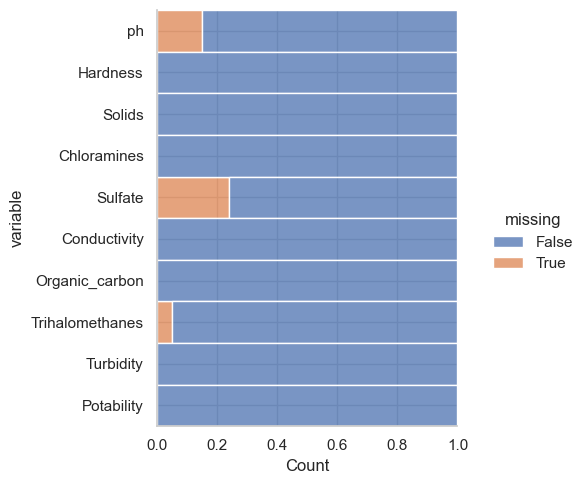

In [15]:
# Get counts of NaN and plot distribution of missing values
sns.displot(data=water.isna().melt(value_name='missing'), y='variable', hue='missing',
            multiple='fill', aspect=1
            )
plt.show()

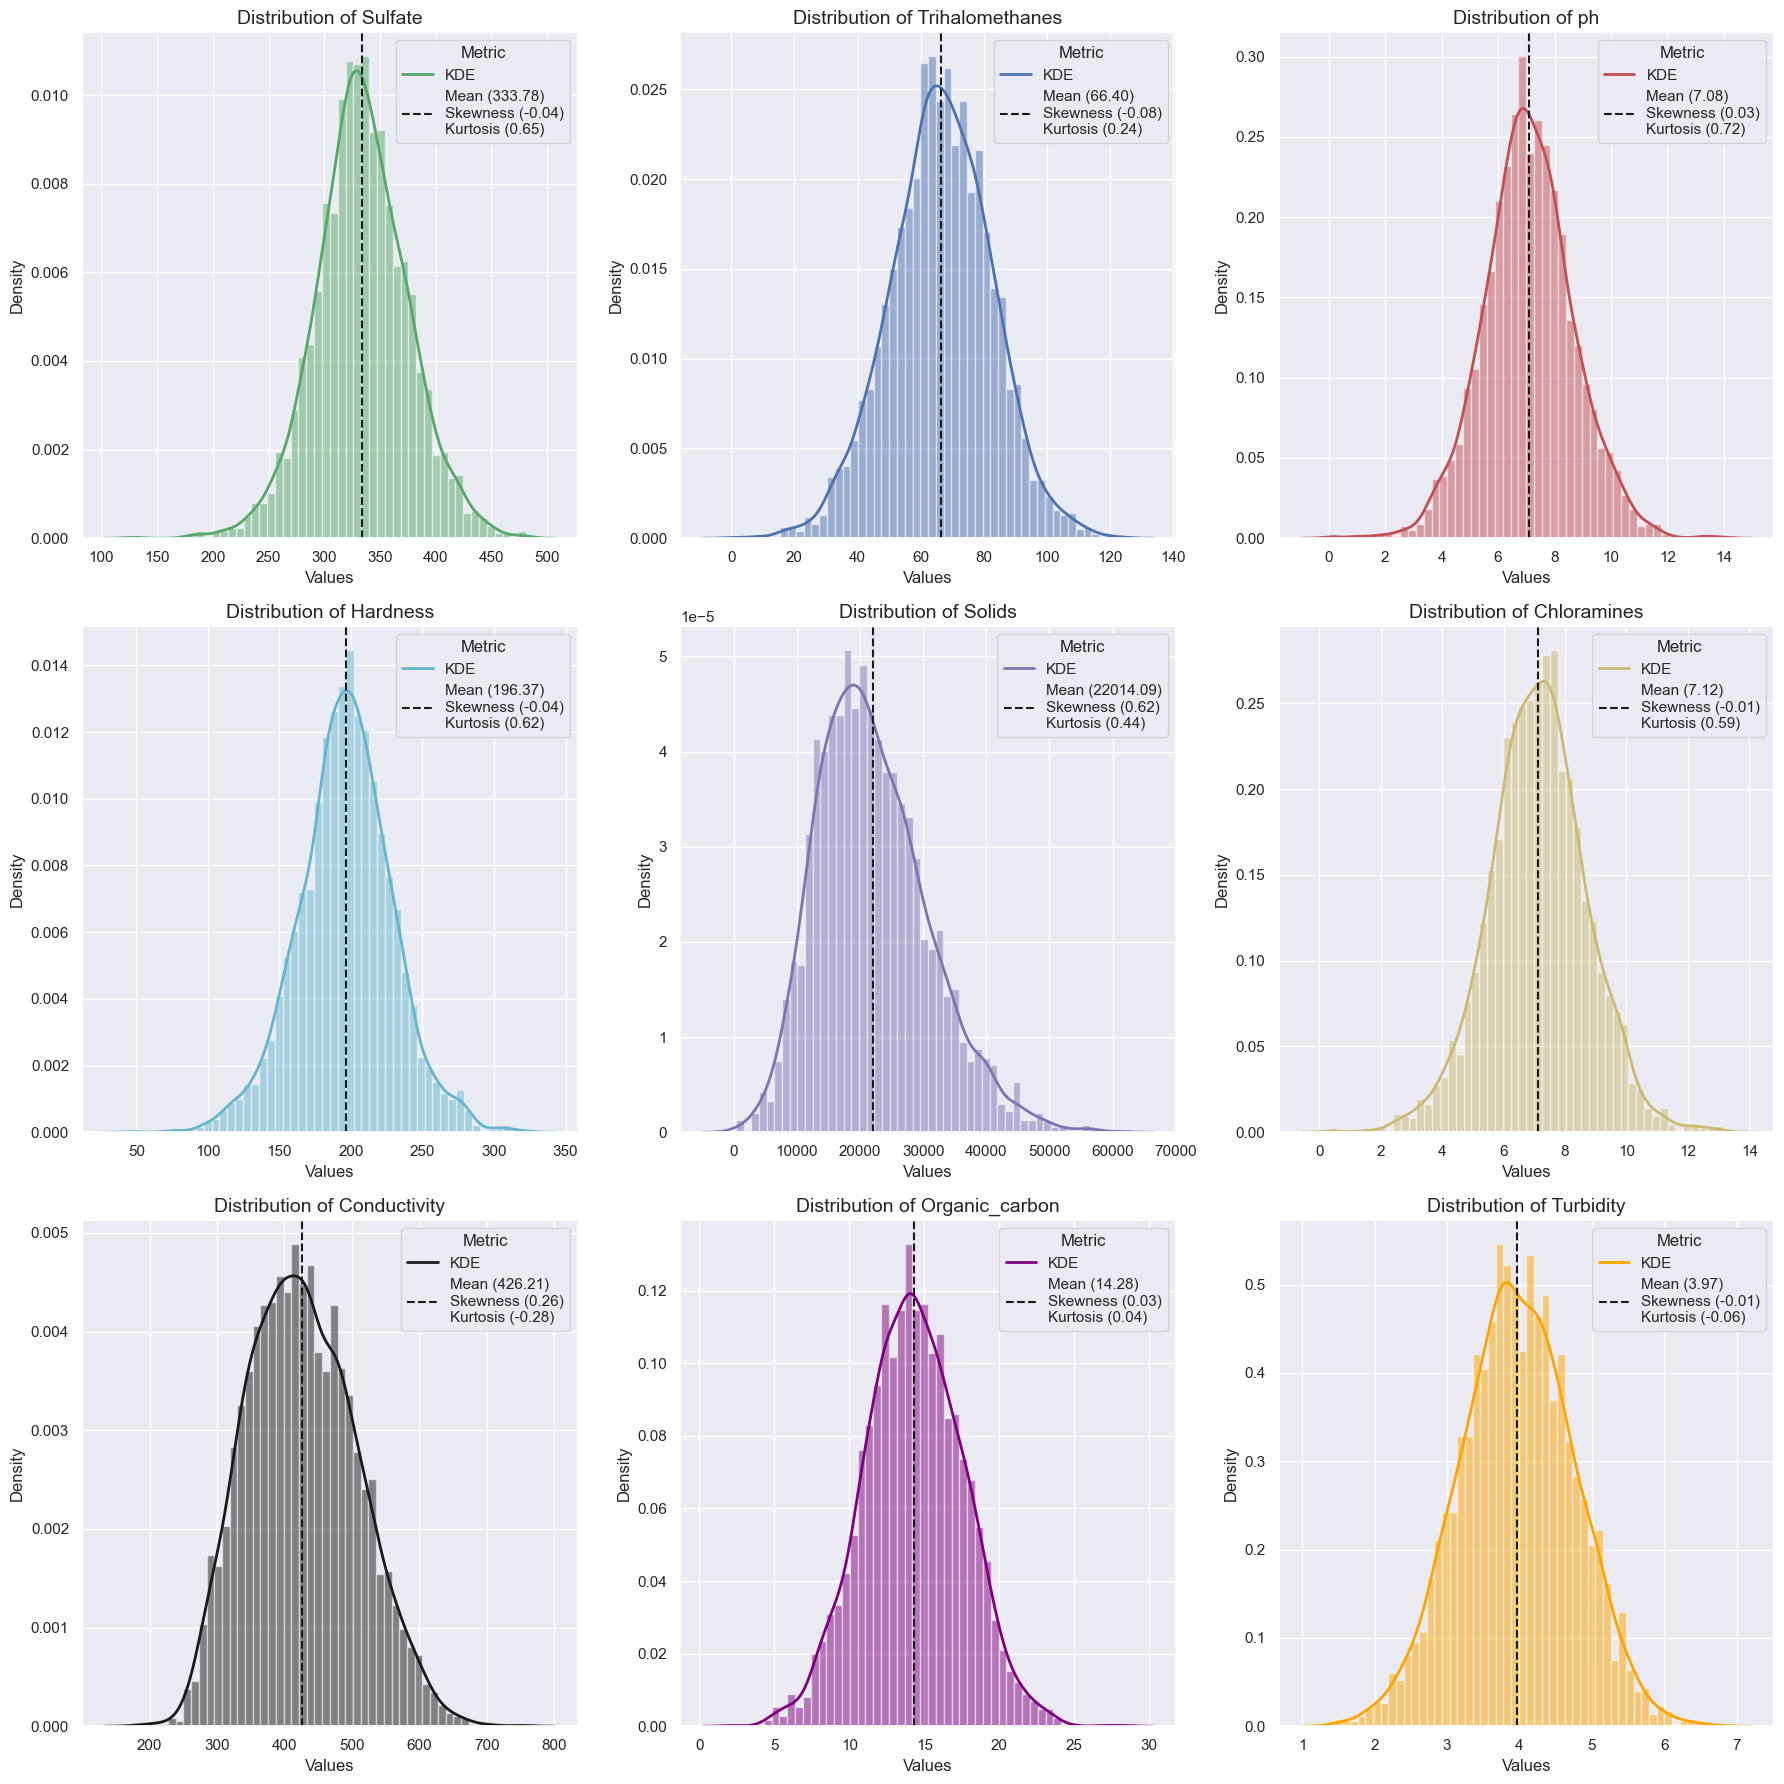

In [58]:
# Columns to plot
columns_to_plot = ['Sulfate', 'Trihalomethanes', 'ph', 'Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Turbidity']

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
sns.set(style="darkgrid")

colors = ['g', 'b', 'r', 'c', 'm', 'y', 'k', 'purple', 'orange']  # Different colors for each plot

for i, (column, color) in enumerate(zip(columns_to_plot, colors)):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    water_miss_vals = water[[column]]
    labels = [column]
    
    # Calculate mean value
    mean_value = water_miss_vals.mean().values[0]
    
    # Calculate skewness
    skewness = water_miss_vals[column].skew()
    
    # Calculate kurtosis
    kurtosis = water_miss_vals[column].kurtosis()
    
    # Histogram with KDE Overlay
    ax.hist(water_miss_vals[column], bins=50, color=color, alpha=0.5, density=True)  # Plot histogram bars
    sns.kdeplot(data=water_miss_vals, x=column, color=color, ax=ax, linewidth=2, label=f'KDE')  # Overlay KDE plot
    
    # Plot mean value, skewness, and kurtosis
    ax.axvline(x=mean_value, color='k', linestyle='--', label=f'Mean ({mean_value:.2f})\nSkewness ({skewness:.2f})\nKurtosis ({kurtosis:.2f})')
    
    ax.set_xlabel('Values')
    ax.set_ylabel('Density')
    ax.set_title(f'Distribution of {column}', fontsize=14)
    ax.legend(title='Metric', loc='upper right')  # Include mean, skewness, and kurtosis in the legend
    ax.grid(True)

plt.tight_layout()

# Save the plot to the "plots" folder
output_folder = './plots/'
output_filename = 'feature_distributions.png'
output_path = output_folder + output_filename
plt.savefig(output_path)

plt.show()

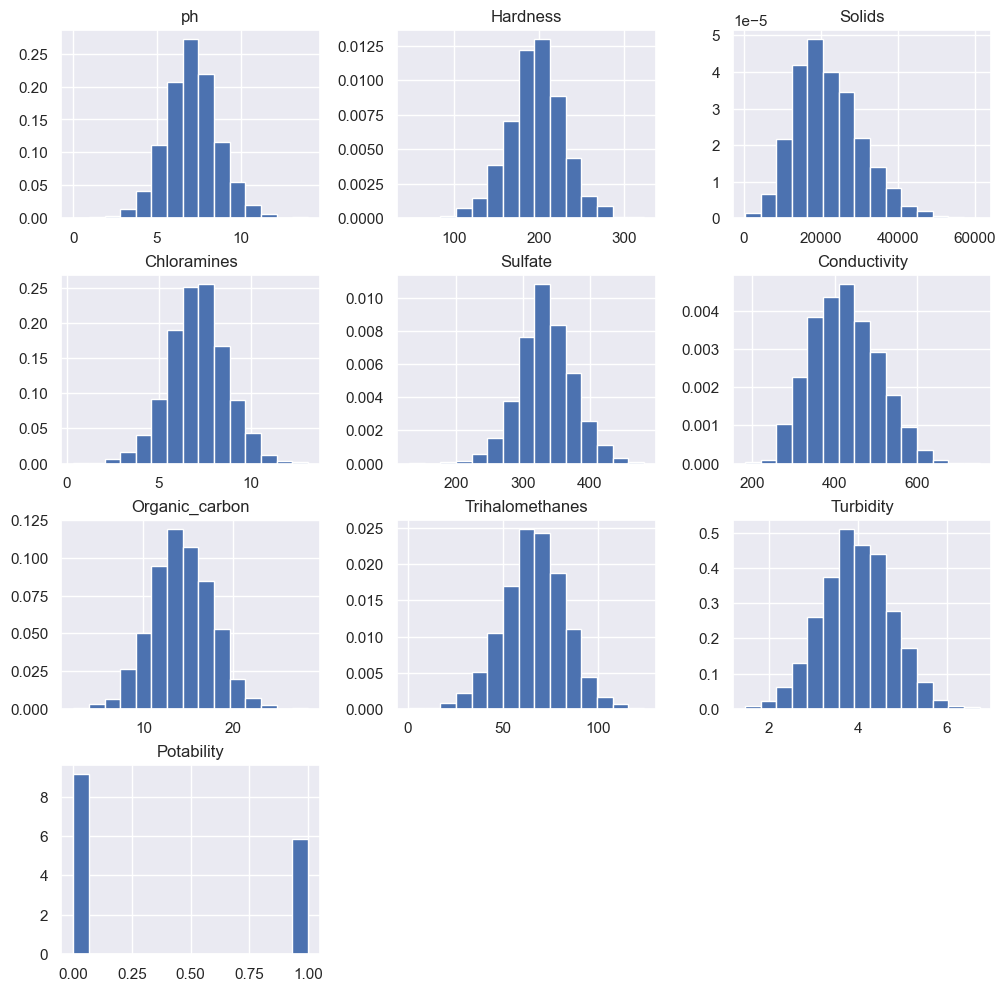

In [34]:
# View distribution of variables
water.hist(bins=15, figsize=(12,12), density=True)
plt.show()

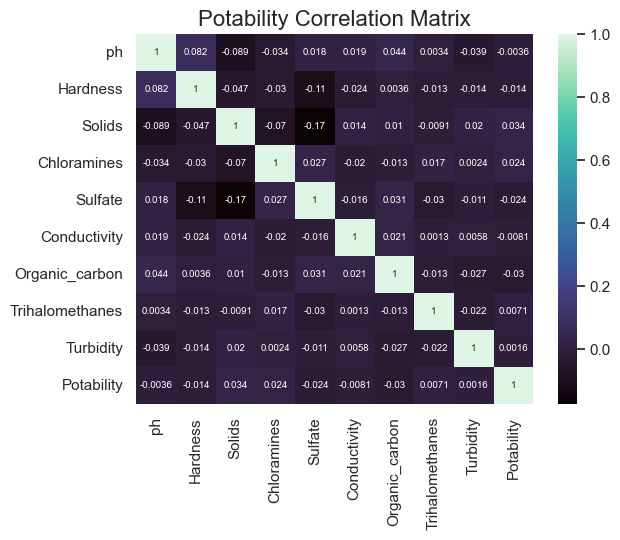

In [10]:
# Correlation matrix
sns.heatmap(data=water.corr(), cmap='mako', annot=True, annot_kws={"size": 7})
plt.title('Potability Correlation Matrix', size=16)
plt.show()

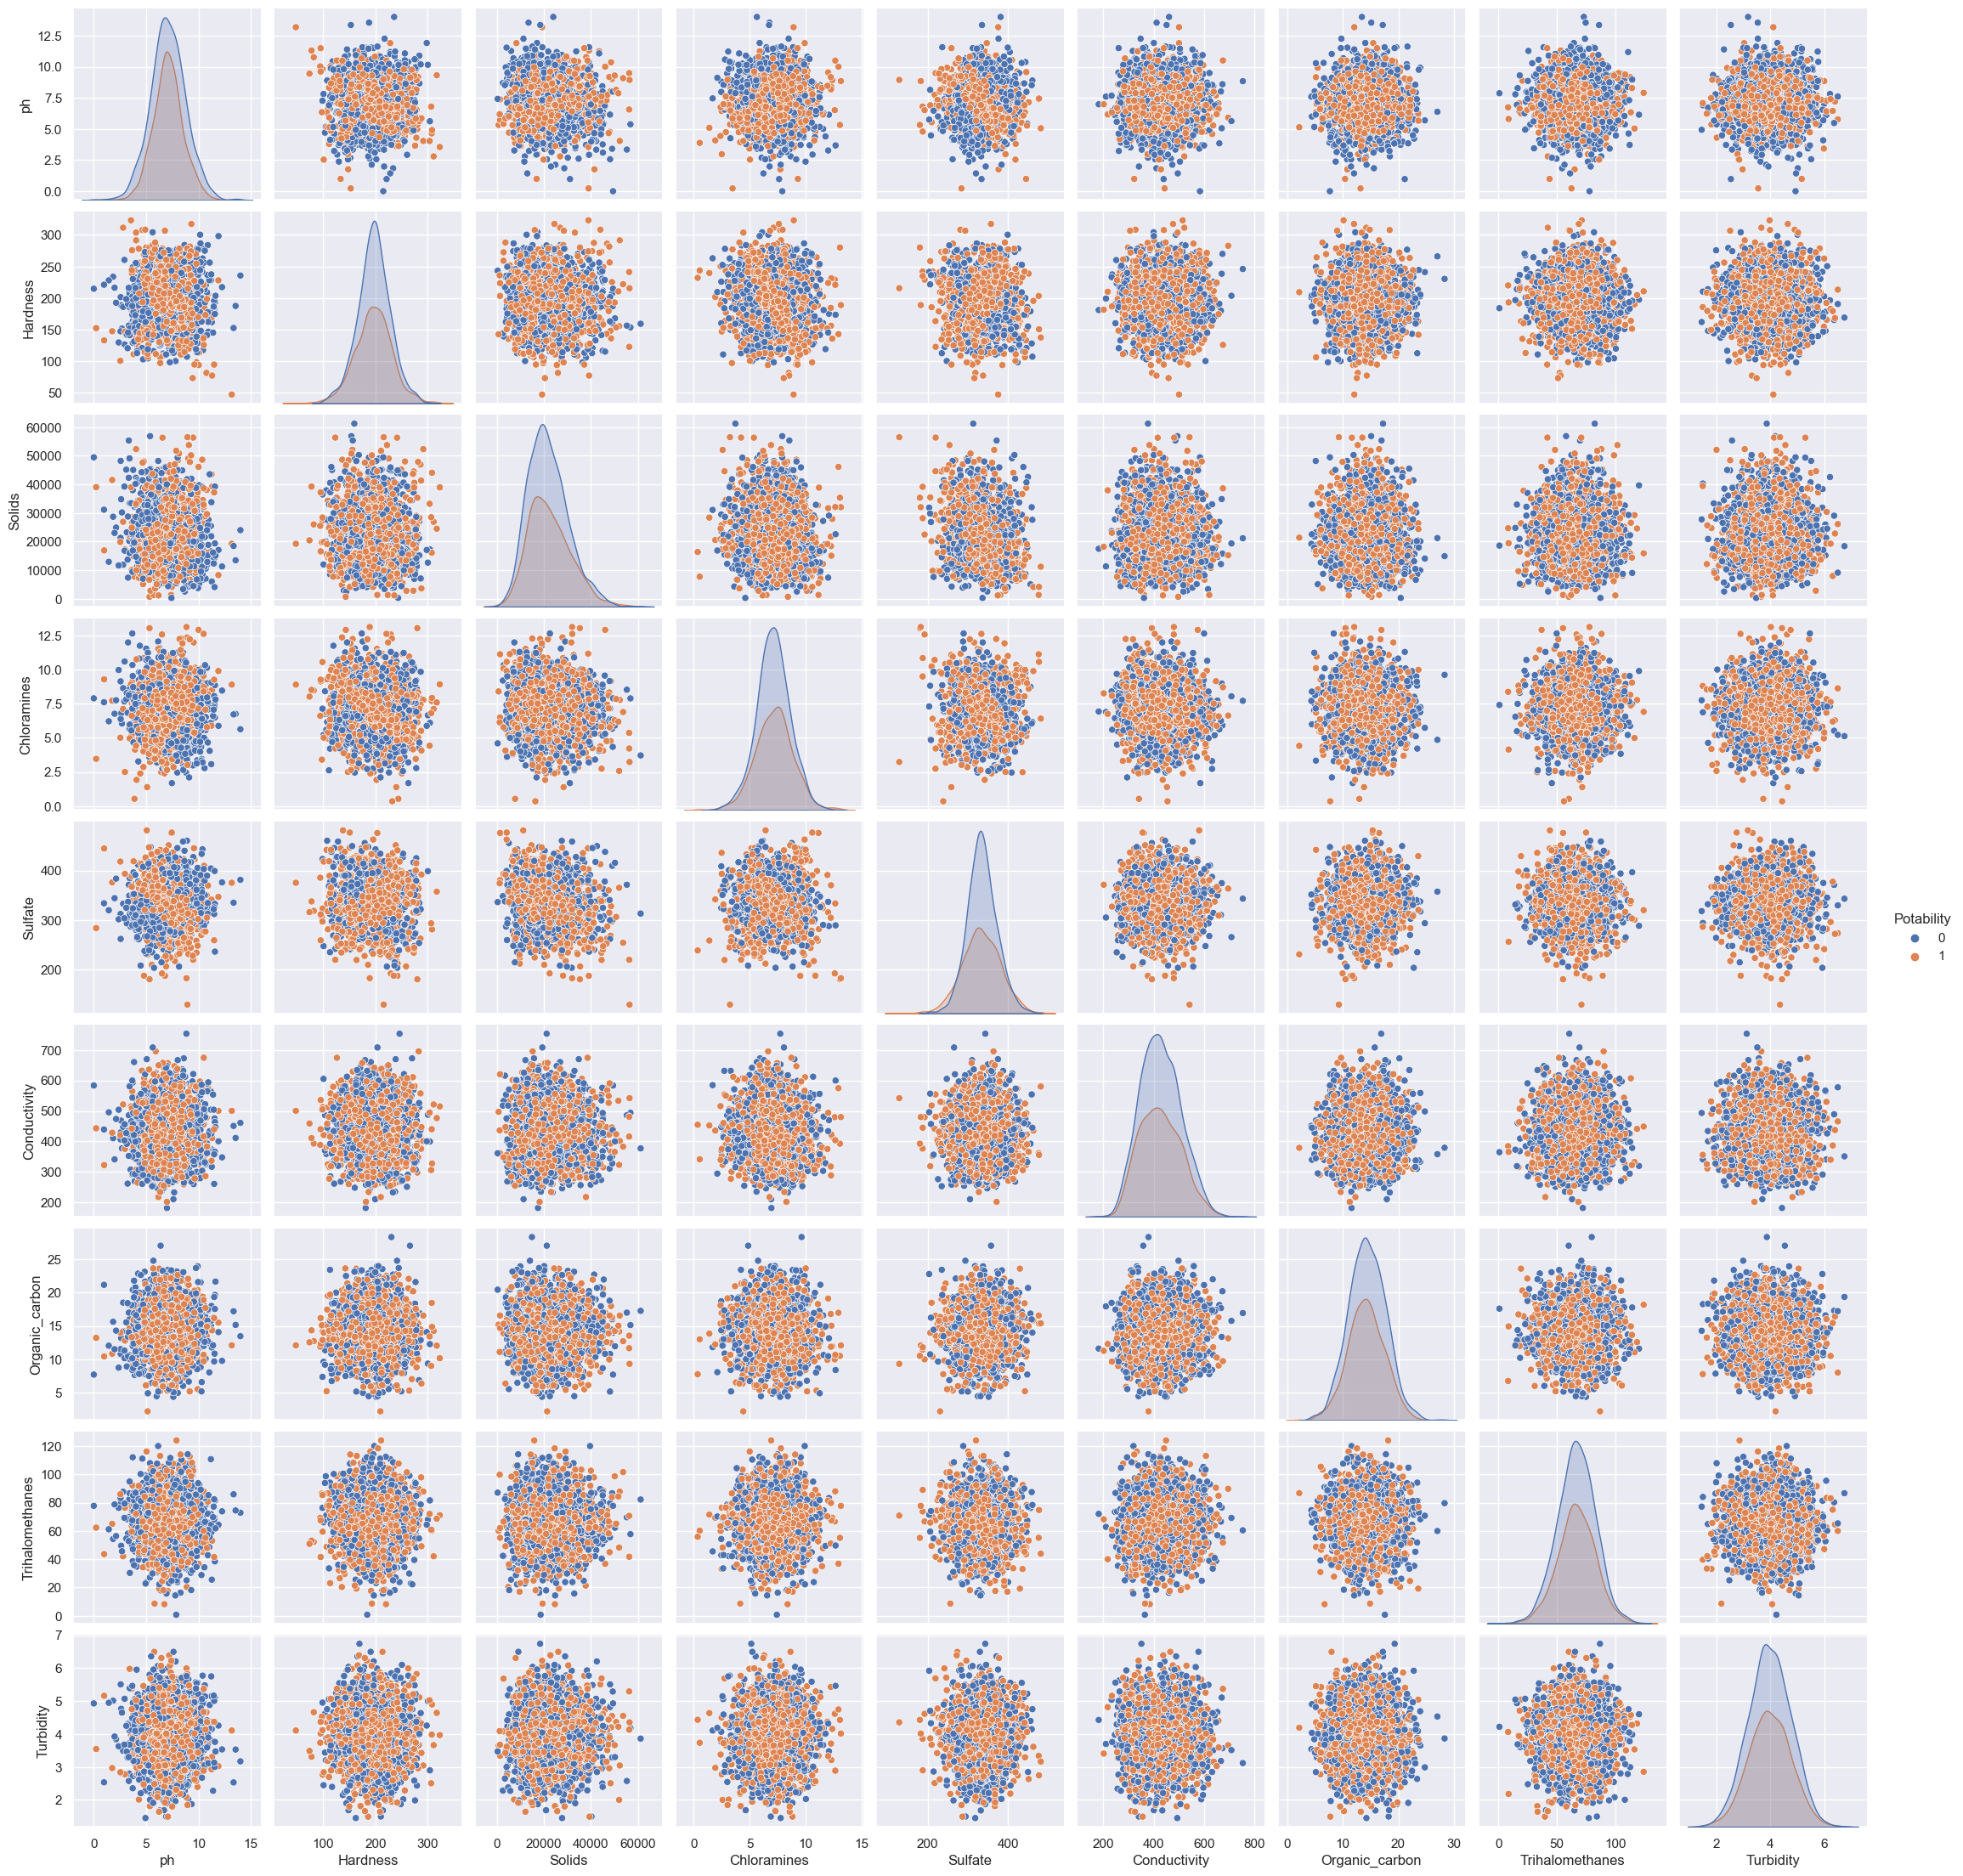

In [51]:
# Distributions
sns.pairplot(water, hue='Potability')
plt.show()

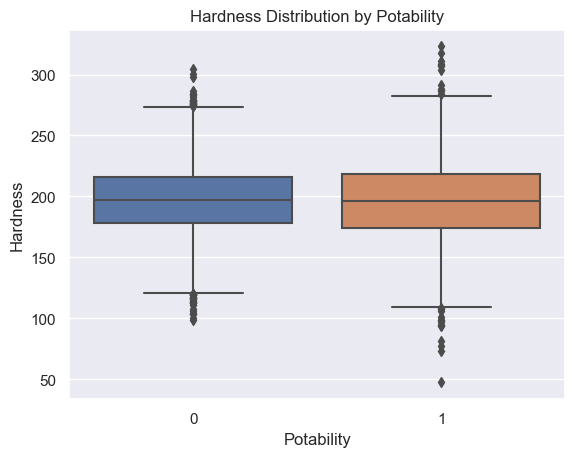

In [11]:
# Exploring the relationship between potability and hardness
sns.boxplot(x='Potability', y='Hardness', data=water)
plt.xlabel('Potability')
plt.ylabel('Hardness')
plt.title('Hardness Distribution by Potability')
plt.show()

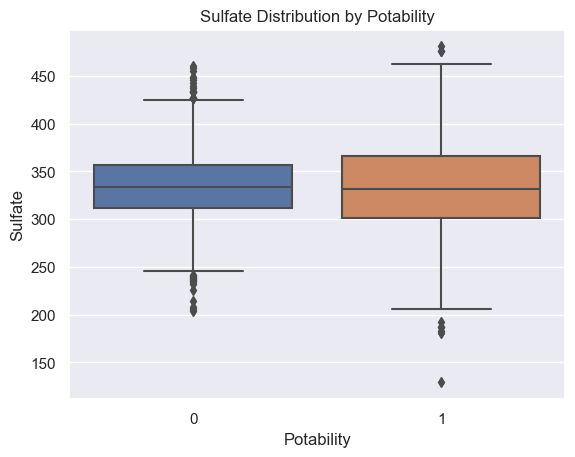

In [52]:
# Exploring the relationship between potability and sulfate
sns.boxplot(x='Potability', y='Sulfate', data=water)
plt.xlabel('Potability')
plt.ylabel('Sulfate')
plt.title('Sulfate Distribution by Potability')
plt.show()

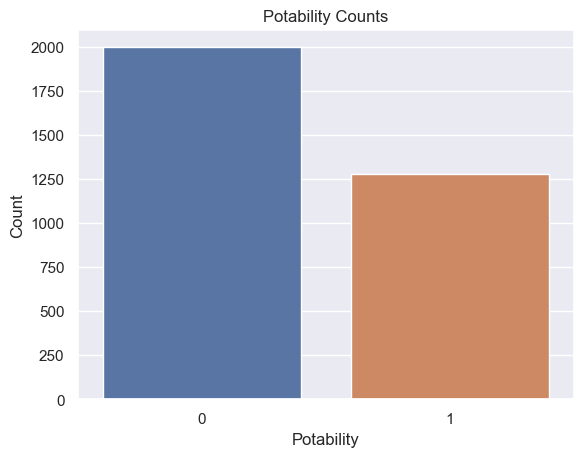

In [13]:
# Exploring the target variable class balance
sns.countplot(x='Potability', data=water)
plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Potability Counts')
plt.show()

In [28]:
# Proportions of the Potability (dependent variable) labels
label_cts = water['Potability'].value_counts()
label_dec = list(round((label_cts / len(water)), 2))
label_perc = [(str(label) + '%') for label in label_dec]

print(f"Potable: {label_perc[0]}")
print(f"Not Potable: {label_perc[1]}")

Potable: 0.61%
Not Potable: 0.39%


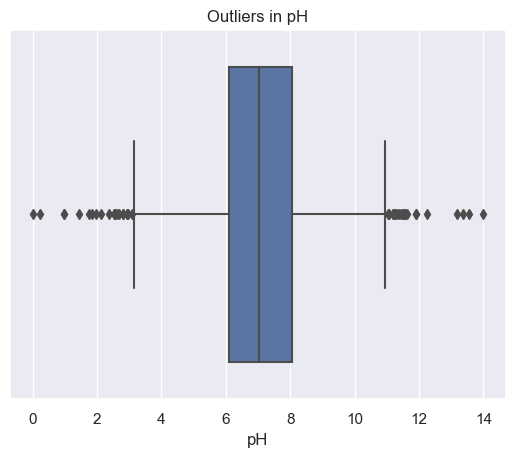

In [14]:
# Exploring outliers in the predictor variables
sns.boxplot(x=water['ph'])
plt.xlabel('pH')
plt.title('Outliers in pH')
plt.show()

## Model Training